In [67]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_implicit_solvent.utils import remove_top_right_spines
%matplotlib inline

In [68]:
path = '../bayes_implicit_solvent/rjmc_experiments/elaborate_tree_rjmc_run_n_compounds=642_n_iter=1000_gaussian_ll.pkl'

In [69]:
from pickle import load

with open(path, 'rb') as f:
    result = load(f)

In [70]:
result.keys()

dict_keys(['traj', 'log_probs', 'log_acceptance_probabilities'])

In [71]:
traj = result['traj']

In [72]:
log_probs = result['log_probs']

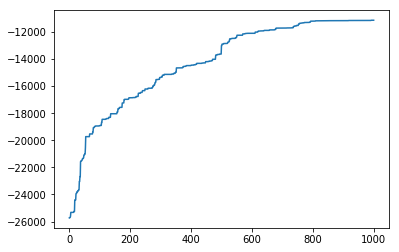

In [73]:
plt.plot(log_probs)

In [74]:
traj[0]

*          (r = 1.50 Å, s = 0.80)
|-[#1]     (r = 1.20 Å, s = 0.85)
|-[#6]     (r = 1.70 Å, s = 0.72)
|-[#7]     (r = 1.55 Å, s = 0.79)
|-[#8]     (r = 1.50 Å, s = 0.85)
|-[#9]     (r = 1.50 Å, s = 0.88)
|-[#15]    (r = 1.85 Å, s = 0.86)
|-[#16]    (r = 1.80 Å, s = 0.96)

In [75]:
traj[-1]

*              (r = 1.43 Å, s = 1.03)
|-[#1]         (r = 1.01 Å, s = 0.89)
|-[#6]         (r = 1.60 Å, s = 0.84)
  |-[#6&X3]    (r = 1.78 Å, s = 0.81)
  |-[#6&X2]    (r = 2.08 Å, s = 0.92)
|-[#7]         (r = 1.39 Å, s = 0.76)
  |-[#7&a]     (r = 1.32 Å, s = 0.79)
|-[#8]         (r = 1.66 Å, s = 0.92)
  |-[#8&X2]    (r = 1.38 Å, s = 0.90)
|-[#9]         (r = 2.05 Å, s = 0.73)
|-[#15]        (r = 1.89 Å, s = 0.78)
|-[#16]        (r = 2.20 Å, s = 0.85)

In [76]:
from bayes_implicit_solvent.continuous_parameter_experiments.gradient_free import mols

In [77]:
mol = mols[0]

In [109]:

from simtk import unit

from simtk import unit
from bayes_implicit_solvent.constants import beta
def unreduce(value):
    """Input value is in units of kB T, turn it into units of kilocalorie_per_mole"""
    return value / (beta * unit.kilocalorie_per_mole)

def make_predictions(tree):
    predictions = []
    for mol in mols:
        radii = tree.assign_radii(mol.mol) / unit.nanometer
        scales = tree.assign_scale_factors(mol.mol)
        predictions.append(mol.predict_solvation_free_energy(radii, scales)[0])
    return unreduce(np.array(predictions))

In [110]:
initial_predictions = make_predictions(traj[0])

In [111]:
final_predictions = make_predictions(traj[-1])

In [112]:
expt_values = unreduce(np.array([mol.experimental_value for mol in mols]))

In [113]:
(np.sqrt(np.mean((initial_predictions - expt_values)**2)))

2.5135307617515825

In [114]:
(np.sqrt(np.mean((final_predictions - expt_values)**2)))

1.8568471847954378

In [115]:
np.random.seed(0)
all_inds = np.arange(len(mols))
np.random.shuffle(all_inds)
train_inds = all_inds[::2]
test_inds = all_inds[1::2]

In [116]:
train_rmse = (np.sqrt(np.mean((final_predictions[train_inds] - expt_values[train_inds])**2)))
test_rmse = (np.sqrt(np.mean((final_predictions[test_inds] - expt_values[test_inds])**2)))
train_rmse, test_rmse

(1.7718684518385128, 1.938103486593241)

In [117]:
len(traj)

1001

In [198]:
from tqdm import tqdm
thinning = 1
prediction_traj = [make_predictions(tree) for tree in tqdm(traj[::thinning])]

100%|██████████| 1001/1001 [1:40:21<00:00,  5.61s/it]


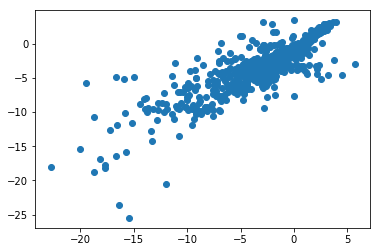

In [199]:
plt.scatter(prediction_traj[0], expt_values)

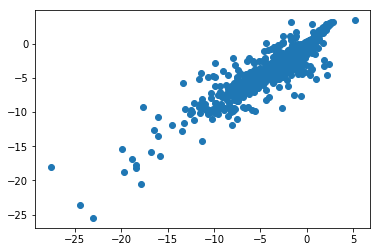

In [200]:
plt.scatter(prediction_traj[-1], expt_values)

In [201]:
tree

*              (r = 1.43 Å, s = 1.03)
|-[#1]         (r = 1.01 Å, s = 0.89)
|-[#6]         (r = 1.60 Å, s = 0.84)
  |-[#6&X3]    (r = 1.78 Å, s = 0.81)
  |-[#6&X2]    (r = 2.08 Å, s = 0.92)
|-[#7]         (r = 1.39 Å, s = 0.76)
  |-[#7&a]     (r = 1.32 Å, s = 0.79)
|-[#8]         (r = 1.66 Å, s = 0.92)
  |-[#8&X2]    (r = 1.38 Å, s = 0.90)
|-[#9]         (r = 2.05 Å, s = 0.73)
|-[#15]        (r = 1.89 Å, s = 0.78)
|-[#16]        (r = 2.20 Å, s = 0.85)

In [202]:
len(prediction_traj)

1001

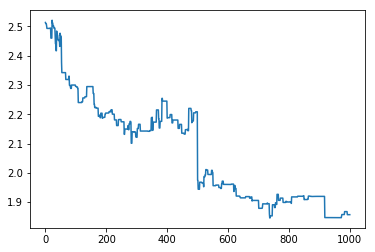

In [203]:
rmses = [np.sqrt(np.mean((snapshot - expt_values)**2)) for snapshot in prediction_traj]
plt.plot(rmses)

In [204]:
train_rmses = [np.sqrt(np.mean((snapshot[train_inds] - expt_values[train_inds])**2)) for snapshot in prediction_traj]
test_rmses = [np.sqrt(np.mean((snapshot[test_inds] - expt_values[test_inds])**2)) for snapshot in prediction_traj]

In [205]:
x = np.arange(len(result['traj']))[::thinning]
x

array([   0,    1,    2, ...,  998,  999, 1000])

(1.7553590624516795, 1.9271592101230681)

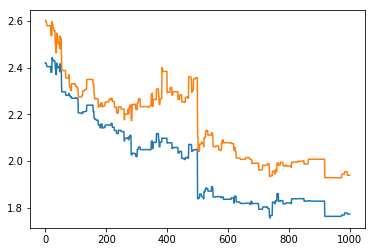

In [206]:
plt.plot(x, train_rmses)
plt.plot(x, test_rmses)

min(train_rmses), min(test_rmses)

In [396]:
train_label = 'train (n={})'.format(n_train)
test_label = 'test (n={})'.format(n_test)

In [397]:
train_color = 'lightblue'
test_color = 'green'
train_style = '--'
test_style = '-'

In [398]:
n_total = sum(expt_values > -15)
n_total

631

In [391]:
len(expt_values)

642

In [663]:
train_mask = train_inds[expt_values[train_inds] > -15]
test_mask = test_inds[expt_values[test_inds] > -15]

n_train = len(train_mask)
n_test = len(test_mask)

train_rmses = np.array([np.sqrt(np.mean((snapshot[train_mask] - expt_values[train_mask])**2)) for snapshot in prediction_traj])
test_rmses = np.array([np.sqrt(np.mean((snapshot[test_mask] - expt_values[test_mask])**2)) for snapshot in prediction_traj])



(1.7655892161001587, 1.8440923650675092)

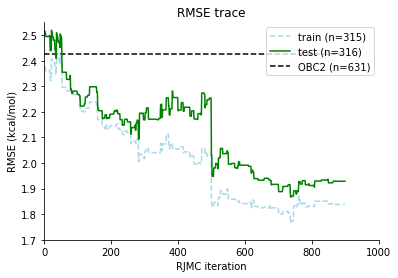

In [704]:
ax = plt.subplot(111)

def plot_rmses(ax, t=900):
    remove_top_right_spines(ax)

    ax.plot(x[:t], train_rmses[:t], label=train_label, c=train_color, linestyle=train_style)
    ax.plot(x[:t], test_rmses[:t], label=test_label, c=test_color, linestyle=test_style)
    

    ax.hlines(obc2_rmse, 0, max(x[:t]), linestyles='--', label='OBC2 (n={})'.format(n_total))
    
    #ax.legend(loc='lower left')
    ax.legend(loc='upper right')
    ax.set_xlim(0, len(x))
    
    ax.set_title('RMSE trace')
    
    
    ax.set_ylim(1.7,2.55)
    ax.set_ylabel('RMSE (kcal/mol)')
    ax.set_xlabel('RJMC iteration')

plot_rmses(ax, t=900)
min(train_rmses), min(test_rmses)

In [327]:
all_types = set()
for tree in traj:
    all_types.update(tree.nodes)
all_types = sorted(list(all_types))

In [328]:
all_types

['*',
 '[#15]',
 '[#16&a]',
 '[#16]',
 '[#1]',
 '[#6&X2]',
 '[#6&X3]',
 '[#6]',
 '[#7&X1]',
 '[#7&a]',
 '[#7]',
 '[#8&X2]',
 '[#8]',
 '[#9]']

In [329]:
import seaborn as sns
color_list = sns.color_palette(palette="husl", n_colors=len(all_types))
#color_list = color_list + color_list
color_dict = dict(zip(all_types, color_list))

In [330]:
# for line-plot representation
x = np.arange(len(traj))
ys = [np.zeros(len(traj)) * np.nan for _ in all_types]
c = [color_dict[t] for t in all_types]

type_dict = dict(zip(all_types, range(len(all_types))))

for time, tree in enumerate(traj):
    for n in tree.nodes:
        i = type_dict[n]
        ys[i][time] = tree.get_radius(n) / unit.angstrom

In [615]:
# for line-plot representation

ys_scales = [np.zeros(len(traj)) * np.nan for _ in all_types]
for time, tree in enumerate(traj):
    for n in tree.nodes:
        i = type_dict[n]
        ys_scales[i][time] = tree.get_scale_factor(n)

In [331]:
change_points = [np.where(np.diff(np.isnan(y)))[0] for y in ys]
change_points

[array([], dtype=int64),
 array([], dtype=int64),
 array([799, 947]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([500]),
 array([31]),
 array([], dtype=int64),
 array([575, 879]),
 array([382]),
 array([], dtype=int64),
 array([481]),
 array([], dtype=int64),
 array([], dtype=int64)]

In [332]:
all_change_points = sorted(np.hstack(change_points))
all_change_points

[31, 382, 481, 500, 575, 799, 879, 947]

In [486]:
for i in all_change_points:
    print(i-2)
    print(traj[i-2])
    print('\n')
print(len(traj) - 1)
print(traj[-1])

29
*          (r = 1.56 Å, s = 0.82)
|-[#1]     (r = 1.20 Å, s = 0.85)
|-[#6]     (r = 1.74 Å, s = 0.73)
|-[#7]     (r = 1.55 Å, s = 0.79)
|-[#8]     (r = 1.45 Å, s = 0.86)
|-[#9]     (r = 1.55 Å, s = 0.89)
|-[#15]    (r = 2.01 Å, s = 0.87)
|-[#16]    (r = 1.80 Å, s = 0.96)


380
*              (r = 1.28 Å, s = 0.91)
|-[#1]         (r = 1.05 Å, s = 0.87)
|-[#6]         (r = 1.46 Å, s = 0.82)
  |-[#6&X3]    (r = 1.78 Å, s = 0.79)
|-[#7]         (r = 1.51 Å, s = 0.77)
|-[#8]         (r = 1.50 Å, s = 0.86)
|-[#9]         (r = 1.79 Å, s = 0.76)
|-[#15]        (r = 2.32 Å, s = 0.80)
|-[#16]        (r = 2.11 Å, s = 0.91)


479
*              (r = 1.43 Å, s = 0.93)
|-[#1]         (r = 1.01 Å, s = 0.88)
|-[#6]         (r = 1.45 Å, s = 0.83)
  |-[#6&X3]    (r = 1.78 Å, s = 0.79)
|-[#7]         (r = 1.51 Å, s = 0.77)
  |-[#7&a]     (r = 1.43 Å, s = 0.78)
|-[#8]         (r = 1.50 Å, s = 0.86)
|-[#9]         (r = 1.82 Å, s = 0.74)
|-[#15]        (r = 1.98 Å, s = 0.79)
|-[#16]        (r = 2.21 Å, s

In [333]:
list(map(len, change_points))

[0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0]

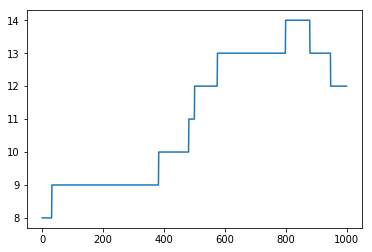

In [487]:
n_types = [tree.number_of_nodes for tree in traj]
plt.plot(n_types)

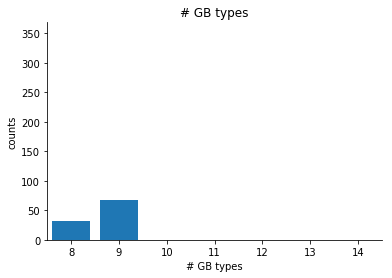

In [706]:
def plot_marginal(ax, t=900):
    
    y_types = np.bincount(n_types)
    x_types = np.arange(len(y_types))
    
    max_y = np.max(y_types)
    
    start_ind = np.argmax(y_types > 0)

    real_y_types = np.bincount(n_types[:t], minlength = len(y_types))
    
    ax.bar(x_types[start_ind:], real_y_types[start_ind:])
    
    ax.set_ylim(0, max_y * 1.05)
    
    remove_top_right_spines(ax)
    
    ax.set_xlim(x_types[start_ind] - 0.5, max(x_types) + 0.5)
    
    ax.set_xlabel('# GB types')
    ax.set_ylabel('counts')
    ax.set_title('# GB types')
    
ax = plt.subplot(1,1,1)
plot_marginal(ax, t=100)

array([ 0,  0,  0,  0,  0,  0,  0,  0, 10])

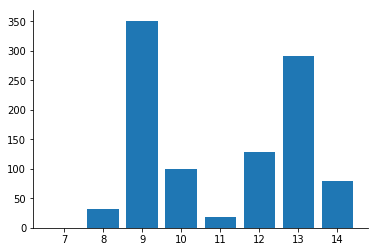

In [632]:
traj[0]

*          (r = 1.50 Å, s = 0.80)
|-[#1]     (r = 1.20 Å, s = 0.85)
|-[#6]     (r = 1.70 Å, s = 0.72)
|-[#7]     (r = 1.55 Å, s = 0.79)
|-[#8]     (r = 1.50 Å, s = 0.85)
|-[#9]     (r = 1.50 Å, s = 0.88)
|-[#15]    (r = 1.85 Å, s = 0.86)
|-[#16]    (r = 1.80 Å, s = 0.96)

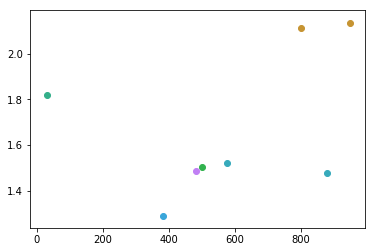

In [334]:
for i, change_point_traj in enumerate(change_points):
    if len(change_point_traj) > 0:
        plt.scatter(x[change_point_traj], ys[i][change_point_traj - 1], c=[c[i]]*len(change_point_traj))
        plt.scatter(x[change_point_traj], ys[i][change_point_traj + 1], c=[c[i]]*len(change_point_traj))

In [623]:
radii_min = np.min(np.array(ys)[np.isfinite(ys)])
radii_max = np.max(np.array(ys)[np.isfinite(ys)])
radii_min, radii_max

(1.009462659762402, 2.416875669787944)

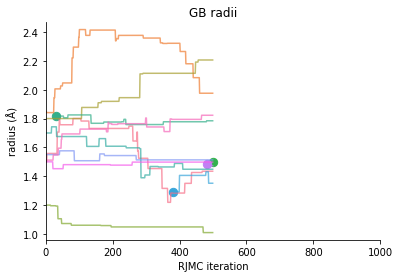

In [656]:
def plot_radii(ax, t=1000):
    s = 70
    for i in range(len(all_types)):
        ax.plot(x[:t], ys[i][:t], c=c[i], alpha=0.7)
    for i, change_point_traj in enumerate(change_points):
        if len(change_point_traj) > 0:
            x_ = x[change_point_traj]
            inds = x_ <= t
            
            #ax.scatter(x_[inds], ys[i][change_point_traj - 1][inds], c=[c[i]]*len(x_[inds]), s=s)
            
            ax.scatter(x_[inds], ys[i][change_point_traj + 1][inds], c=[c[i]]*len(x_[inds]), s=s)
            ax.scatter(x_[inds], ys[i][change_point_traj - 1][inds], c=[c[i]]*len(x_[inds]), s=s)
    #plt.ylim(0,)
    remove_top_right_spines(ax)
    ax.set_xlim(0,max(x))
    ax.set_ylabel('radius (Å)')
    ax.set_ylim(radii_min - 0.05, radii_max + 0.05)
    ax.set_title('GB radii')
    ax.set_xlabel("RJMC iteration")

ax = plt.subplot(111)
plot_radii(ax, t=500)

In [626]:
scales_min = np.min(np.array(ys_scales)[np.isfinite(ys_scales)])
scales_max = np.max(np.array(ys_scales)[np.isfinite(ys_scales)])
scales_min, scales_max

(0.72, 1.0304711226843009)

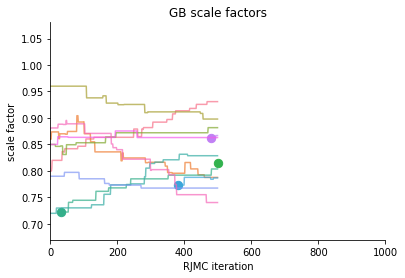

In [655]:
def plot_scales(ax, t=1000):
    s = 70
    for i in range(len(all_types)):
        ax.plot(x[:t], ys_scales[i][:t], c=c[i], alpha=0.7)
    for i, change_point_traj in enumerate(change_points):
        if len(change_point_traj) > 0:
            x_ = x[change_point_traj]
            inds = x_ <= t
            
            #ax.scatter(x_[inds], ys[i][change_point_traj - 1][inds], c=[c[i]]*len(x_[inds]), s=s)
            
            ax.scatter(x_[inds], ys_scales[i][change_point_traj + 1][inds], c=[c[i]]*len(x_[inds]), s=s)
            ax.scatter(x_[inds], ys_scales[i][change_point_traj - 1][inds], c=[c[i]]*len(x_[inds]), s=s)
    #plt.ylim(0,)
    remove_top_right_spines(ax)
    ax.set_xlim(0,max(x))
    ax.set_ylim(scales_min - 0.05, scales_max + 0.05)
    ax.set_ylabel('scale factor')
    ax.set_xlabel('RJMC iteration')
    
    ax.set_title('GB scale factors')

ax = plt.subplot(111)
plot_scales(ax, t=500)

In [355]:
diag = np.arange(-15, 5)

In [659]:
minval = min(prediction_traj[-1][train_mask]) - 0.5
maxval = max(prediction_traj[-1][test_mask]) + 0.5
minval, maxval

(-18.193721826766108, 5.691187986479013)

In [660]:
ticks = [-15,-10,-5,0,5]

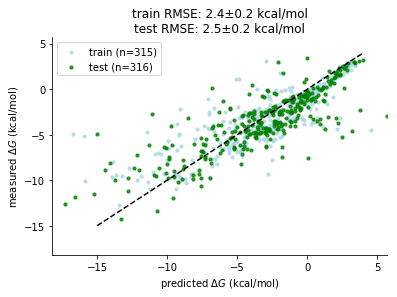

In [712]:
def plot_bayesian_scatter(ax, t=990):
    remove_top_right_spines(ax)
    ax.scatter(prediction_traj[t][train_mask], expt_values[train_mask], alpha=0.8, s=10, c=train_color, label=train_label)
    ax.scatter(prediction_traj[t][test_mask], expt_values[test_mask], alpha=0.8, s=10, c=test_color, label=test_label)
    ax.legend()
    ax.plot(diag, diag, color='black', linestyle='--')
    ax.set_xlabel(r'predicted $\Delta G$ (kcal/mol)')
    ax.set_ylabel(r'measured $\Delta G$ (kcal/mol)')
    
    ax.set_xlim(minval, maxval)
    ax.set_ylim(minval, maxval)
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    plt.title('train RMSE: {:.1f}±{:.1} kcal/mol\ntest RMSE: {:.1f}±{:.1} kcal/mol'.format(train_rmses[t], bootstrapped_train_d_rmses[t], test_rmses[t], bootstrapped_test_d_rmses[t]))
    
    
ax = plt.subplot(111)
plot_bayesian_scatter(ax, t=0)

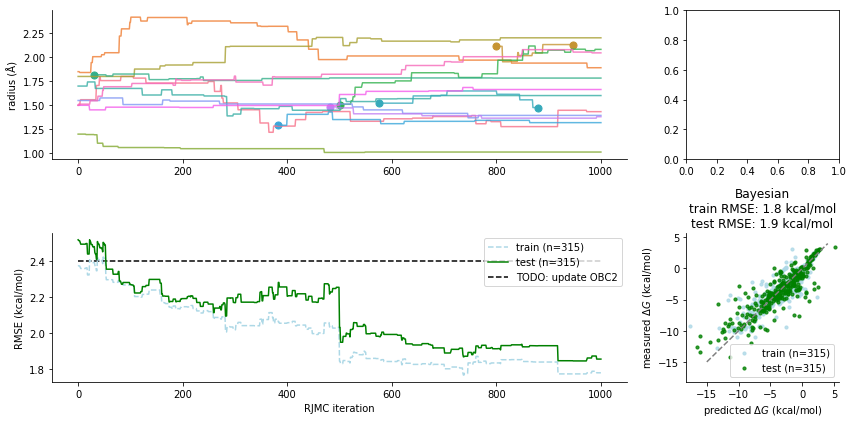

In [377]:
plt.figure(figsize=(4*3, 2*3))
grid_size = (2,4)

ax1 = plt.subplot2grid(grid_size, (0, 0), colspan=3)
ax2 = plt.subplot2grid(grid_size, (1, 0), colspan=3)
ax3 = plt.subplot2grid(grid_size, (0, 3))
ax4 = plt.subplot2grid(grid_size, (1, 3))

plot_radii(ax1)
plot_rmses(ax2)
plot_bayesian_scatter(ax4)

plt.tight_layout()

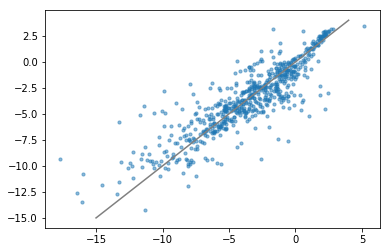

In [337]:
# 

plt.scatter(prediction_traj[-1][expt_values > -15], expt_values[expt_values > -15], alpha=0.5, s=10)
plt.plot(diag, diag, color='grey')

In [265]:
running_averaged_predictions = ((np.cumsum(prediction_traj, 0).T / (1 + np.arange(len(prediction_traj))))).T



train_rmses_avged = [np.sqrt(np.mean((snapshot[train_mask] - expt_values[train_mask])**2)) for snapshot in running_averaged_predictions]
test_rmses_avged = [np.sqrt(np.mean((snapshot[test_mask] - expt_values[test_mask])**2)) for snapshot in running_averaged_predictions]


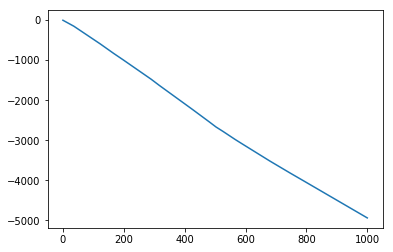

In [266]:
plt.plot(np.cumsum(prediction_traj, 0)[:,0])

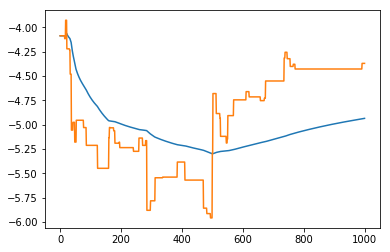

In [267]:
plt.plot(np.cumsum(prediction_traj, 0)[:,0] / (1 + np.arange(len(prediction_traj))))
plt.plot(np.array(prediction_traj)[:,0])

In [268]:
np.cumsum(prediction_traj, 0)[1:].T

array([[-8.17123403e+00, -1.22568510e+01, -1.63424681e+01, ...,
        -4.93076032e+03, -4.93512959e+03, -4.93949886e+03],
       [-5.94175869e+00, -8.91263803e+00, -1.18835174e+01, ...,
        -4.85546829e+03, -4.86000668e+03, -4.86454506e+03],
       [-5.46994126e+00, -8.20491188e+00, -1.09398825e+01, ...,
        -3.59520601e+03, -3.59900597e+03, -3.60280593e+03],
       ...,
       [-7.90193883e+00, -1.18529082e+01, -1.58038777e+01, ...,
        -3.84787288e+03, -3.85125695e+03, -3.85464102e+03],
       [ 2.78331943e+00,  4.17497915e+00,  5.56663887e+00, ...,
         1.05310051e+03,  1.05398797e+03,  1.05487542e+03],
       [ 2.16215144e+00,  3.24322715e+00,  4.32430287e+00, ...,
         4.67448993e+02,  4.67267759e+02,  4.67086524e+02]])

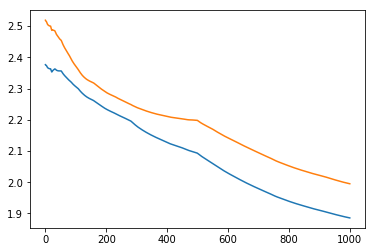

In [269]:
plt.plot(train_rmses_avged)
plt.plot(test_rmses_avged)

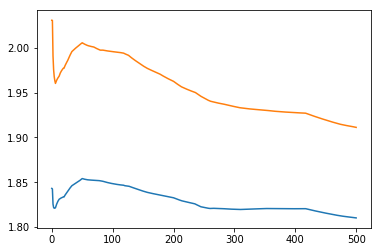

In [271]:
running_averaged_predictions = ((np.cumsum(prediction_traj[500:], 0).T / (1 + np.arange(len(prediction_traj[500:]))))).T

train_rmses_avged = [np.sqrt(np.mean((snapshot[train_mask] - expt_values[train_mask])**2)) for snapshot in running_averaged_predictions]
test_rmses_avged = [np.sqrt(np.mean((snapshot[test_mask] - expt_values[test_mask])**2)) for snapshot in running_averaged_predictions]

plt.plot(train_rmses_avged)
plt.plot(test_rmses_avged)



In [272]:
min(train_rmses_avged), min(train_rmses)

(1.8101671963746278, 1.7655892161001587)

In [226]:
min(rmses)

1.84572895737493

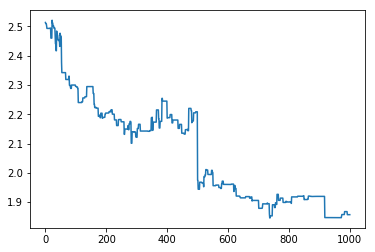

In [224]:
plt.plot(rmses)

In [417]:
mbondi2_preds = unreduce(np.load('mbondi2_preds.npy'))[:,0]

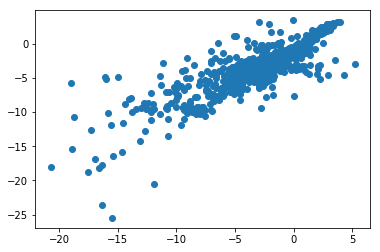

In [418]:
plt.scatter(mbondi2_preds, expt_values)

In [518]:
def rmse(x, y):
    squared_errors = (x - y)**2
    mean_squared_errors = np.mean(squared_errors)
    root_mean_squared_errors = np.sqrt(mean_squared_errors)
    
    N = len(x)
    standard_error = np.std(squared_errors) / np.sqrt(N)
    
    return root_mean_squared_errors, standard_error

In [519]:
rmse(mbondi2_preds, expt_values)

(2.4858168943120744, 0.5884897353709747)

In [520]:
rmse(mbondi2_preds[expt_values > -15], expt_values[expt_values > -15])

(2.425900278028874, 0.5646329474804053)

In [606]:
def bootstrapped_error_for_rmse(x, y, n_bootstrap=1000):
    N = len(x)
    rmses = []
    for _ in range(n_bootstrap):
        mask = np.random.randint(0,N,N)
        rmses.append(rmse(x[mask], y[mask])[0])
    return rmses

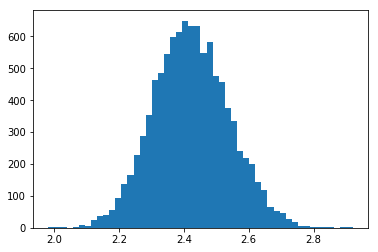

In [534]:
bootstrapped_rmses = bootstrapped_error_for_rmse(mbondi2_preds[expt_values > -15], expt_values[expt_values > -15])
plt.hist(bootstrapped_rmses, bins=50);

In [535]:
bootstrapped_obc2_d_rmse = np.std(bootstrapped_rmses)
bootstrapped_obc2_d_rmse

0.11656464667276507

In [536]:
bootstrapped_train_d_rmse = np.std(bootstrapped_error_for_rmse(final_predictions[train_inds], expt_values[train_inds]))
bootstrapped_train_d_rmse

0.11919382345939748

In [607]:
bootstrapped_train_d_rmses = np.array([np.std(bootstrapped_error_for_rmse(prediction_traj[t][train_inds], expt_values[train_inds])) for t in tqdm(range(len(prediction_traj)))])
bootstrapped_train_d_rmses[:5]

100%|██████████| 1001/1001 [00:55<00:00, 18.06it/s]


array([0.1692337 , 0.16591266, 0.16549442, 0.16579341, 0.16668564])

In [608]:
bootstrapped_test_d_rmses = np.array([np.std(bootstrapped_error_for_rmse(prediction_traj[t][test_inds], expt_values[test_inds])) for t in tqdm(range(len(prediction_traj)))])
bootstrapped_test_d_rmses[:5]

100%|██████████| 1001/1001 [00:54<00:00, 18.21it/s]


array([0.17815207, 0.17834841, 0.18561684, 0.17818594, 0.17235913])

In [532]:
bootstrapped_test_d_rmse = np.std(bootstrapped_error_for_rmse(final_predictions[test_inds], expt_values[test_inds]))
bootstrapped_test_d_rmse

0.1291743780744571

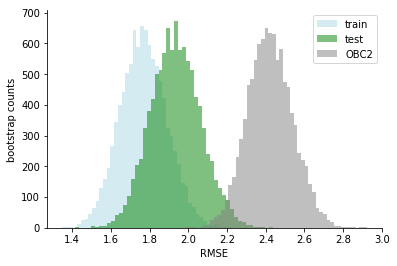

In [561]:
ax = plt.subplot(111)
remove_top_right_spines(ax)
plt.hist(bootstrapped_error_for_rmse(final_predictions[train_inds], expt_values[train_inds]), bins=50,
         color=train_color, alpha=0.5, label='train')
plt.hist(bootstrapped_error_for_rmse(final_predictions[test_inds], expt_values[test_inds]), bins=50,
         color=test_color, alpha=0.5, label='test')
plt.hist(bootstrapped_rmses, bins=50, label='OBC2', color='grey', alpha=0.5);


plt.ylabel('bootstrap counts')
plt.xlabel('RMSE')
plt.legend()

In [547]:
obc2_rmse, d_rmse = rmse(mbondi2_preds[expt_values > -15], expt_values[expt_values > -15])
obc2_rmse

2.425900278028874

In [571]:
def plot_obc2(ax):
    mask = expt_values > -15
    
    
    
    remove_top_right_spines(ax)
    x_ = np.array(mbondi2_preds[mask])
    y_ = np.array(expt_values[mask])
    print(len(x_), len(y_))
    print(x_.shape, y_.shape)
    ax.scatter(x_, y_, alpha=0.6, s=10, c='grey', label='(n={})'.format(n_total))
    #ax.scatter(prediction_traj[-1][train_mask], expt_values[train_mask], alpha=0.8, s=10, c=train_color, label=train_label)
    #ax.scatter(prediction_traj[-1][test_mask], expt_values[test_mask], alpha=0.8, s=10, c=test_color, label=test_label)
    ax.legend(loc='lower right')
    ax.plot(diag, diag, color='black', linestyle='--')
    ax.set_xlabel(r'predicted $\Delta G$ (kcal/mol)')
    ax.set_ylabel(r'measured $\Delta G$ (kcal/mol)')
    
    ax.set_xlim(minval, maxval)
    ax.set_ylim(minval, maxval)
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    ax.set_title('OBC2\nRMSE: {:.1f}±{:.1} kcal/mol'.format(obc2_rmse, bootstrapped_obc2_d_rmse))

    

In [572]:
bootstrapped_obc2_d_rmse

0.11656464667276507

In [573]:
mask = expt_values > -15
len(mbondi2_preds[mask]), len(expt_values[mask])

(631, 631)

631 631
(631,) (631,)


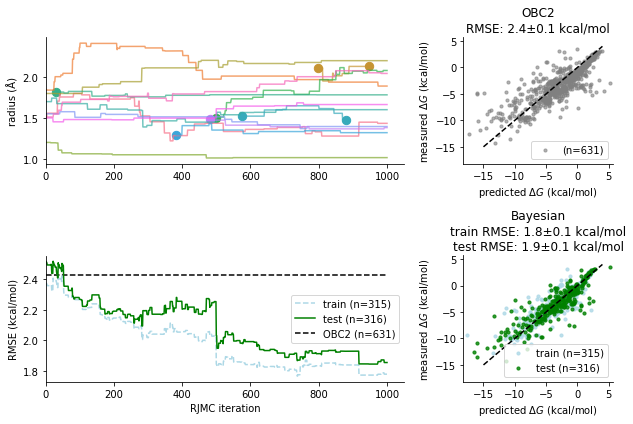

In [579]:
plt.figure(figsize=(3*3, 2*3))
grid_size = (2,3)

ax1 = plt.subplot2grid(grid_size, (0, 0), colspan=2)
ax2 = plt.subplot2grid(grid_size, (1, 0), colspan=2)
ax3 = plt.subplot2grid(grid_size, (0, 2))
ax4 = plt.subplot2grid(grid_size, (1, 2))

plot_radii(ax1)

plot_rmses(ax2, obc2_rmse=obc2_rmse)
plot_obc2(ax3)
plot_bayesian_scatter(ax4)

plt.tight_layout()

plt.savefig('squared_away.png', dpi=300)

In [575]:
all_change_points

[31, 382, 481, 500, 575, 799, 879, 947]

In [576]:
traj[32]

*              (r = 1.56 Å, s = 0.82)
|-[#1]         (r = 1.19 Å, s = 0.85)
|-[#6]         (r = 1.74 Å, s = 0.73)
  |-[#6&X3]    (r = 1.82 Å, s = 0.72)
|-[#7]         (r = 1.55 Å, s = 0.79)
|-[#8]         (r = 1.45 Å, s = 0.86)
|-[#9]         (r = 1.55 Å, s = 0.89)
|-[#15]        (r = 2.01 Å, s = 0.87)
|-[#16]        (r = 1.80 Å, s = 0.96)

In [577]:
traj[0]

*          (r = 1.50 Å, s = 0.80)
|-[#1]     (r = 1.20 Å, s = 0.85)
|-[#6]     (r = 1.70 Å, s = 0.72)
|-[#7]     (r = 1.55 Å, s = 0.79)
|-[#8]     (r = 1.50 Å, s = 0.85)
|-[#9]     (r = 1.50 Å, s = 0.88)
|-[#15]    (r = 1.85 Å, s = 0.86)
|-[#16]    (r = 1.80 Å, s = 0.96)

In [ ]:
traj[200]

In [584]:
s = str(traj[0])

In [689]:
s = str(traj[990])
s

'*              (r = 1.43 Å, s = 1.03)\n|-[#1]         (r = 1.01 Å, s = 0.89)\n|-[#6]         (r = 1.60 Å, s = 0.84)\n  |-[#6&X3]    (r = 1.78 Å, s = 0.81)\n  |-[#6&X2]    (r = 2.08 Å, s = 0.92)\n|-[#7]         (r = 1.39 Å, s = 0.76)\n  |-[#7&a]     (r = 1.32 Å, s = 0.79)\n|-[#8]         (r = 1.66 Å, s = 0.92)\n  |-[#8&X2]    (r = 1.37 Å, s = 0.89)\n|-[#9]         (r = 2.05 Å, s = 0.73)\n|-[#15]        (r = 1.89 Å, s = 0.78)\n|-[#16]        (r = 2.20 Å, s = 0.85)'

In [690]:
print(s)

*              (r = 1.43 Å, s = 1.03)
|-[#1]         (r = 1.01 Å, s = 0.89)
|-[#6]         (r = 1.60 Å, s = 0.84)
  |-[#6&X3]    (r = 1.78 Å, s = 0.81)
  |-[#6&X2]    (r = 2.08 Å, s = 0.92)
|-[#7]         (r = 1.39 Å, s = 0.76)
  |-[#7&a]     (r = 1.32 Å, s = 0.79)
|-[#8]         (r = 1.66 Å, s = 0.92)
  |-[#8&X2]    (r = 1.37 Å, s = 0.89)
|-[#9]         (r = 2.05 Å, s = 0.73)
|-[#15]        (r = 1.89 Å, s = 0.78)
|-[#16]        (r = 2.20 Å, s = 0.85)


In [694]:
s.splitlines()[0].find('(r'), s.splitlines()[-1].find('(r')

(15, 15)

In [695]:
'\n'.join(s.splitlines()) == s

True

In [696]:
def remove_continuous_parameters(s):
    lines =  s.splitlines()
    ind = lines[0].find('(r')
    return '\n'.join([line[:ind] for line in lines])

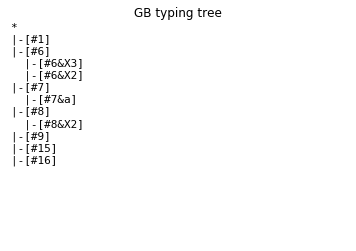

In [709]:
ax =plt.subplot(1,1,1)

def plot_tree(ax, t=0):
    s = remove_continuous_parameters(str(traj[t]))
    ax.text(0,1,s,transform=ax.transAxes, fontsize=11, fontdict={'family': 'monospace'},
            verticalalignment='top')#, bbox=props)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title('GB typing tree')
plot_tree(ax, t=-1)

In [713]:
def plot_frame(t=500):
    plt.figure(figsize=(3*3, 2*3))
    grid_size = (2,3)

    ax1 = plt.subplot2grid(grid_size, (0, 0))
    ax2 = plt.subplot2grid(grid_size, (1, 0))
    ax3 = plt.subplot2grid(grid_size, (0, 1))
    ax4 = plt.subplot2grid(grid_size, (1, 1))
    ax5 = plt.subplot2grid(grid_size, (0, 2))
    ax6 = plt.subplot2grid(grid_size, (1, 2))
    
    plot_tree(ax1, t=t)
    plot_marginal(ax2, t=t)
    plot_radii(ax3, t=t)
    plot_scales(ax4, t=t)
    plot_rmses(ax5, t=t)
    plot_bayesian_scatter(ax6, t=t)

    plt.tight_layout()

    plt.savefig('rjmc_animation_march4/{:04}.png'.format(t), dpi=200)
    plt.close()
    
plot_frame(990)

In [714]:
for t in tqdm(range(1, len(prediction_traj))[::10]):
    plot_frame(t)

100%|██████████| 100/100 [01:13<00:00,  1.11it/s]


In [699]:
#np.savez('rjmc_prediction_traj.npz', prediction_traj=prediction_traj,
#         expt_values=expt_values, train_inds=train_inds, test_inds=test_inds,
#        )